In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
def resizeTemplateToFitImage(image, template):
    # Obtenemos las dimensiones de la imagen y el template
    h_img, w_img = image.shape[:2]
    h_template, w_template = template.shape[:2]

    # Calculamos los factores de escala para ajustar el template a la imagen
    scale_factor_w = w_img / w_template
    scale_factor_h = h_img / h_template

    # Escogemos el factor de escala más pequeño para mantener la relación de aspecto
    scale_factor = min(scale_factor_w, scale_factor_h)

    # Redimensionamos el template
    new_w = int(w_template * scale_factor)
    new_h = int(h_template * scale_factor)
    resized_template = cv.resize(template, (new_w, new_h), interpolation=cv.INTER_AREA)

    return resized_template

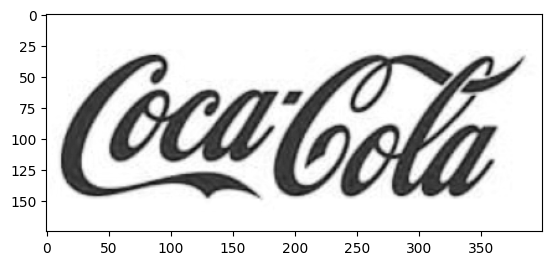

In [3]:
# Cargamos el template
template = cv.imread('assets\\template\\pattern.png', 0)

plt.figure()
plt.imshow(template, cmap='gray')

## Ejercicio 1

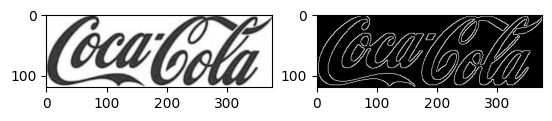

In [4]:
# Recorto template para tener un mejor match
x1, y1 = 10, 30  # Coordenadas de la esquina superior izquierda
x2, y2 = 385, 150  # Coordenadas de la esquina inferior derecha
trimmed_template = template[y1:y2, x1:x2]
template_canny = cv.Canny(trimmed_template, 100, 200)

plt.figure()
plt.subplot(121),plt.imshow(trimmed_template, cmap='gray')
plt.subplot(122),plt.imshow(template_canny, cmap='gray')
plt.show()

In [5]:
def preProcessImage(image: np.ndarray, max_limit: int) -> np.ndarray:
    # remove_noise = cv.GaussianBlur(image, (3,3), 0)
    canny = cv.Canny(image, 100, max_limit)
    return canny

In [6]:
def matchTemplate_new(image, template, method):
    result = cv.matchTemplate(image, template, method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)
    return max_val, max_loc

def chooseBestMatch_new(image, template):
    img_gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    updated_template = resizeTemplateToFitImage(image, template)
    
    methods = [cv.TM_CCOEFF_NORMED]

    best_match = None
    best_score = 0
    best_location = None
    image_copy = image.copy()
    
    sigmas = np.linspace(200, 800, num=10)
    # sigmas = np.linspace(200, 800, num=5)
    
    for sigma in sigmas:
        processed_image = preProcessImage(img_gray, sigma)
        processed_template = preProcessImage(updated_template, 200)
        
        
        scale_factors = np.linspace(0.4, 0.9, num=6)
        # scale_factors = np.linspace(0.2, 0.9, num=16)
        templates = [cv.resize(processed_template, None, fx=scale, fy=scale, interpolation=cv.INTER_AREA) for scale in scale_factors]

        for templ in templates:
            for method in methods:
                score, location = matchTemplate_new(processed_image, templ, method)
                if score > best_score:
                    best_score = score
                    best_match = templ
                    best_location = location

    # Dibujar un rectángulo sobre el mejor match en la imagen original
    w, h = best_match.shape[::-1]
    bottom_right = (best_location[0] + w, best_location[1] + h)
    cv.rectangle(image_copy, best_location, bottom_right, (0,0,255), 2)

    return best_match, best_score, best_location, image_copy

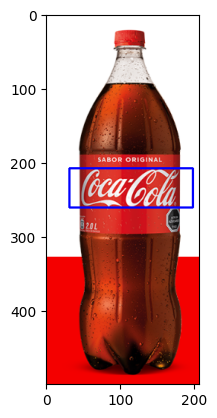

best_score: 0.3179922103881836


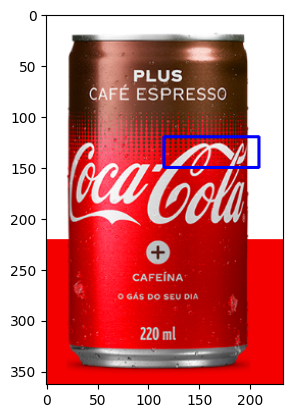

best_score: 0.1463441252708435


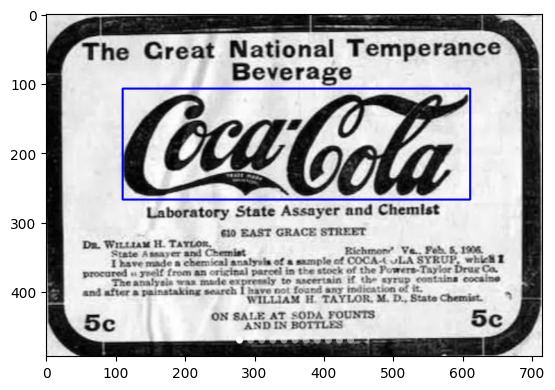

best_score: 0.11166821420192719


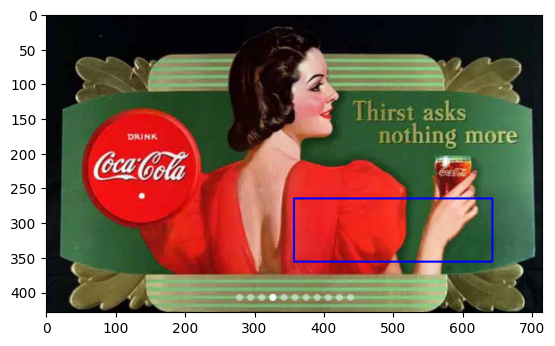

best_score: 0.09806393086910248


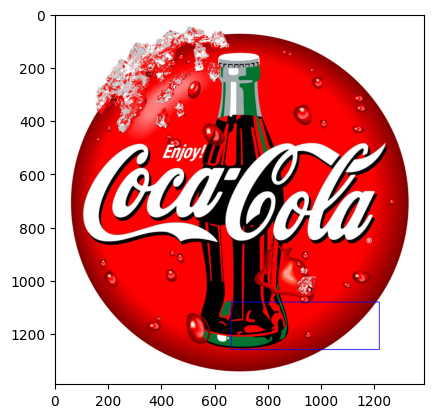

best_score: 0.059939660131931305


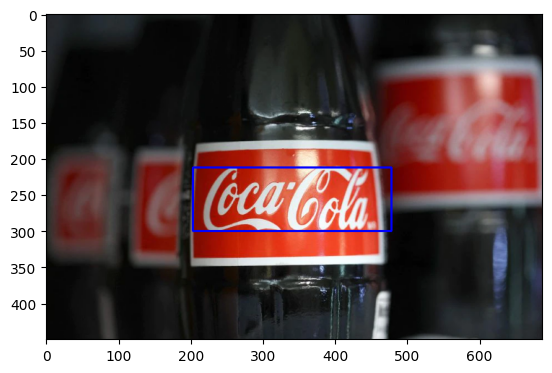

best_score: 0.10692800581455231


In [7]:
# Cargamos las imagenes
base_path = 'assets\images'
image_names = ['coca_logo_1.png', 'coca_logo_2.png', 'coca_retro_1.png', 'coca_retro_2.png', 'COCA-COLA-LOGO.jpg', 'logo_1.png']

images = [cv.imread(f"{base_path}\{path}") for path in image_names]
images_rgb = [cv.cvtColor(image, cv.COLOR_BGR2RGB) for image in images]
images_gray = [cv.cvtColor(image, cv.COLOR_BGR2GRAY) for image in images]

for image in images_rgb:
    best_template, best_score, best_location, prediction = chooseBestMatch_new(image, trimmed_template)
    plt.figure()
    plt.imshow(prediction, cmap="gray")
    plt.show()
    print(f"best_score: {best_score}")

Buscamos en una grilla los parametros para aplicar Canny a las imagenes a procesar. Tambien buscamos en una grilla los tamaños de los templates a matchear. Finalmente calculamos el mejor score y graficamos bounded boxes en cada imagen. Podemos observar de que hay aciertos y desaciertos. Creemos que este metodo de Template Matching dependen mucho de la imagen a procesar, la iluminacion, el contraste, los objetos en la escena, etc para poder lograr un buen match.

Intentando pre-procesas cada imagen individualmente variando los parametros, pudimos conseguir buenos resultados, como mostramos a continuacion:

## Ejercicio 1 - Imagen 2

In [8]:
nuevo_ancho = int(template.shape[1] * 0.4)
nuevo_alto = int(template.shape[0] * 0.4) 
template_red_1 = cv.resize(template, (nuevo_ancho, nuevo_alto))
template_canny = cv.Canny(template_red_1, 100, 200)

In [9]:
img_1 = cv.imread('assets\\images\\coca_logo_1.png')
img_1_rgb = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1_gray = cv.cvtColor(img_1, cv.COLOR_BGR2GRAY)

img_1_canny = cv.Canny(img_1_gray, 100, 200)

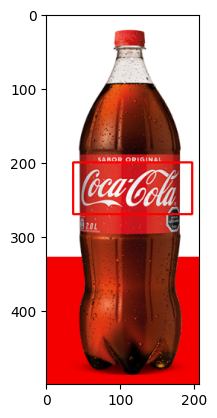

In [10]:
w, h = template_canny.shape[::-1]
res = cv.matchTemplate(img_1_canny,template_canny,cv.TM_CCOEFF_NORMED)
# Fijamos un umbral de "coincidencia"
threshold = 0.2

loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv.rectangle(img_1_rgb, pt, (pt[0] + w, pt[1] + h), (255,0,0), 2)

plt.figure()
plt.imshow(img_1_rgb, cmap="gray")

## Ejercicio 1 - Imagen 2

In [11]:
img_2 = cv.imread('assets\\images\\coca_logo_2.png')
img_2_rgb = cv.cvtColor(img_2, cv.COLOR_BGR2RGB)
img_2_gray = cv.cvtColor(img_2, cv.COLOR_BGR2GRAY)

img_2_canny = cv.Canny(img_2_gray, 100, 200)

In [12]:
nuevo_ancho = int(template.shape[1] * 0.6)
nuevo_alto = int(template.shape[0] * 0.6) 
template_red_2 = cv.resize(template, (nuevo_ancho, nuevo_alto))

In [13]:
# Recorto template para tener un mejor match
# x1, y1 = 10, 30  # Coordenadas de la esquina superior izquierda
# x2, y2 = 386, 150  # Coordenadas de la esquina inferior derecha

x1, y1 = 35, 35  # Coordenadas de la esquina superior izquierda
x2, y2 = 180, 90  # Coordenadas de la esquina inferior derecha

trimmed_template_2 = template_red_2[y1:y2, x1:x2]

template_trim_canny_2 = cv.Canny(trimmed_template_2, 100, 200)

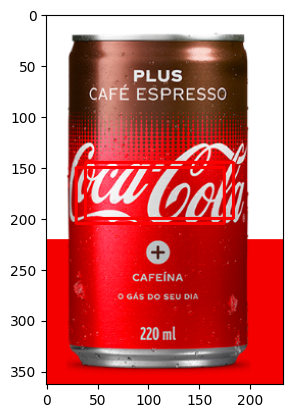

In [14]:
w, h = template_trim_canny_2.shape[::-1]
res = cv.matchTemplate(img_2_canny,template_trim_canny_2,cv.TM_CCOEFF_NORMED)
# Fijamos un umbral de "coincidencia"
threshold = 0.1

loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv.rectangle(img_2_rgb, pt, (pt[0] + w, pt[1] + h), (255,0,0), 2)

plt.figure()
plt.imshow(img_2_rgb, cmap="gray")

## Ejercicio 1 - Imagen 3 Retro_1

In [15]:
# Cargamos la imagen a buscar
img__brute1 = cv.imread('assets\\template\\pattern.png', 0)

# Cargamos la imagen de búsqueda
img2 = cv.imread('assets\\images\\coca_retro_1.png', 0)

# Recorto template para tener un mejor match
# x1, y1 = 10, 30  # Coordenadas de la esquina superior izquierda
# x2, y2 = 386, 150  # Coordenadas de la esquina inferior derecha

x1, y1 = 10, 30  # Coordenadas de la esquina superior izquierda
x2, y2 = 386, 150  # Coordenadas de la esquina inferior derecha

img1 = img__brute1[y1:y2, x1:x2]

In [16]:
# Creamos el vector de características SIFT
sift = cv.SIFT_create()

# Y buscamos según el algoritmo...
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

print(len(kp1))
print(len(kp2))

207
3892


In [17]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

# Guardar todos las buenas coincidencias según la verificación de Ratio de Lowe
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
print(len(good))

26


In [18]:
MIN_MATCH_COUNT = 8

if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts, M)
    img2 = cv.polylines(img2, [np.int32(dst)], True, 0, 3, cv.LINE_AA)
else:
    print( "No se encontraron suficientes coincidencias - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None


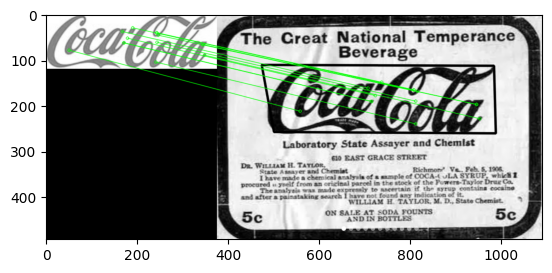

In [19]:
draw_params = dict(matchColor = (0,255,0), # dibujar coincidencias en verde
                   singlePointColor = None,
                   matchesMask = matchesMask, # dibujar solo inliers
                   flags = 2)
img3 = cv.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)

plt.figure()
plt.imshow(img3, 'gray')

Vamos que usando algoritmos de extraccion de caracteristicas (SIFT) obtenemos buenos resultados tambien.

# Ejercicio 2

In [20]:
img_rgb = cv.imread('assets\\images\\coca_multi.png')
img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
img_rgb = cv.cvtColor(img_rgb, cv.COLOR_BGR2RGB)

# Aplicar el detector de bordes Canny
img_canny = cv.Canny(img_gray, 100, 200)

In [21]:
nuevo_ancho = int(template.shape[1] * 0.25)
nuevo_alto = int(template.shape[0] * 0.25) 
template_red_mult = cv.resize(template, (nuevo_ancho, nuevo_alto))

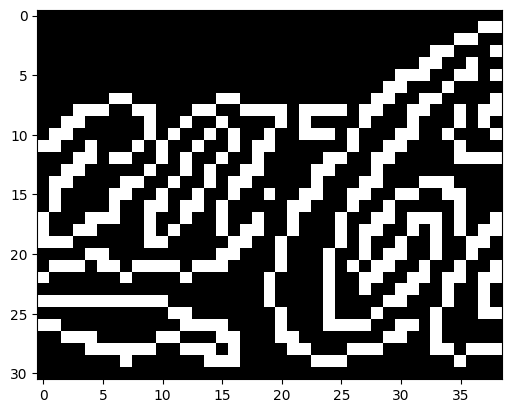

In [22]:
# Recorto template para tener un mejor match
# x1, y1 = 10, 30  # Coordenadas de la esquina superior izquierda
# x2, y2 = 386, 150  # Coordenadas de la esquina inferior derecha

x1, y1 = 26, 7  # Coordenadas de la esquina superior izquierda
x2, y2 = 65, 38  # Coordenadas de la esquina inferior derecha

trimmed_template = template_red_mult[y1:y2, x1:x2]

template_trim_canny = cv.Canny(trimmed_template, 100, 200)
plt.imshow(template_trim_canny, cmap='gray')

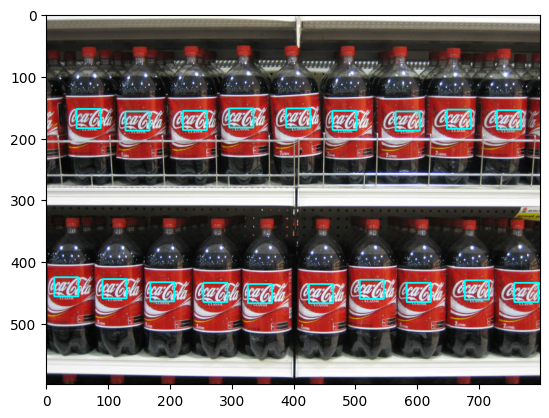

In [23]:
w, h = template_trim_canny.shape[::-1]
res_2= cv.matchTemplate(img_canny,template_trim_canny,cv.TM_CCOEFF_NORMED)
# Fijamos un umbral de "coincidencia"
threshold_2 = 0.25

img_copy = img_rgb.copy()

loc = np.where( res_2 >= threshold_2)
loc = list(zip(*loc[::-1]))

rects = sorted(loc, key=lambda x: x[0])
rects_filtered = []
j=0
rects_filtered.append(rects[0])
for i in range(len(rects)-1):
    if abs(rects_filtered[j][0]-rects[i+1][0]) > 10:
        rects_filtered.append(rects[i+1])
        j=j+1

for rect in rects_filtered:
    cv.rectangle(img_copy, (rect[0], rect[1]), (rect[0] + w, rect[1] + h), (0, 255, 255), 2)

plt.figure()
plt.imshow(img_copy)